In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import powerlaw


matplotlib.rcParams['figure.figsize'] = (15.0, 10.0) # default plots are app. same size as notebook
plt.style.use('ggplot')

In [2]:
import warnings

# Ignore two specific warning messages from the powerlaw package. 
# Comment these lines to show warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")

In [3]:
filepath = "/home/laal/MAG/DATA/NETWORKS/SimpleWeightPsychology2010CentralityGendered.csv"
cent_df = pd.read_csv(filepath, sep="\t")
cent_df.head()

,AuthorId,PageRank,PageRank05,InDegreeStrength,InDegree,OutDegreeStrength,OutDegree,Gender,Rank
0,599318,1.484002e-07,2.958094e-07,0.0,0.0,0.111111,0.111111,1,16691
1,679298,1.484002e-07,2.958094e-07,0.0,0.0,0.333333,0.333333,-1,16101
2,725175,1.508001e-07,2.982382e-07,0.5,4.0,0.000000,0.000000,-1,18818
3,1258017,9.238257e-07,7.202014e-07,27.0,55.0,10.000000,10.000000,1,17764
4,1281797,1.484002e-07,2.958094e-07,0.0,0.0,2.500000,2.500000,1,21135


## Fairness

In [50]:
def plot_group_dist(centrality_df, centrality, interval_size, max_N, protected_group, unprotected, 
                    show_unknown=True, field_name=None, na_removed=False, ax=None, global_rates=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    sorted_df = centrality_df.sort_values(by=centrality, ascending=False)
    
    if global_rates is not None:
        global_rate_protected = global_rates['protected']
        global_rate_unprotected = global_rates['unprotected']
    else:   
        global_rate_protected = sorted_df.Gender.value_counts(normalize=True)[protected_group]
        global_rate_unprotected = sorted_df.Gender.value_counts(normalize=True)[unprotected]
    
    
    xticks = []
    y_values = []
    y_values_unprotected = []
    y_values_unknown = []
    
    for N in range(interval_size, max_N, interval_size):
        
        xticks.append(N)
        top_n_df = sorted_df[:N]
        value_counts = top_n_df.Gender.value_counts(normalize=True)
        
        y_values.append(value_counts[protected_group] if protected_group in value_counts else 0)
        y_values_unprotected.append(value_counts[unprotected] if unprotected in value_counts else 0)
        
        if show_unknown: y_values_unknown.append(value_counts[-1] if -1 in value_counts else 0)
    
    if show_unknown:
        global_rate_unknown = sorted_df.Gender.value_counts(normalize=True)[-1] \
        if global_rates is None else global_rates.get('unknown')
        ax.plot(xticks, y_values_unknown, '-o', label="N/A", markersize=3, color="#b8b8b8", alpha=0.2)
        ax.axhline(y=global_rate_unknown, label="Total population N/A", linestyle='--', alpha=0.8, color="#b8b8b8")
    
    
    ax.plot(xticks, y_values, '-o', label="Female", markersize=6, color="#6fc9f2")
    ax.axhline(y=global_rate_protected, label="Total population female", linestyle='--', alpha=1.0, color="#6fc9f2")
    
    
    ax.plot(xticks, y_values_unprotected, '-o', label="Male", markersize=6, color="#bd8aff")
    ax.axhline(y=global_rate_unprotected, label="Total population male", linestyle='--', alpha=1.0, color="#bd8aff")
    
    if global_rates is None:
        title = "Group proportions in Top N rank ({})".format(centrality)
        title += ": {}".format(field_name) if field_name is not None else ""
        title += "Increment = {}".format(interval_size)
        title += ". N/A removed" if na_removed else ""
        ax.set_title(title, fontsize=12)

    ax.set_ylabel("Proportion")
    ax.set_xlabel("Top N")
    
    ax.legend()
    
    if ax is None:
        plt.show()
    
    return y_values, xticks

In [51]:
def plot_side_by_side(cent_df, field_name, interval=1000, figsize=(15,12), centrality="Pagerank"):
    idx = 0
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=figsize, sharex=False, sharey=True)
    axs = list(axs.flatten())
    
    global_rates = {
        'protected': cent_df.Gender.value_counts(normalize=True)[0],
        'unprotected': cent_df.Gender.value_counts(normalize=True)[1],
        'unknown': cent_df.Gender.value_counts(normalize=True)[-1]
    }
    
    cent_df.sort_values(by=centrality, ascending=False, inplace=True)
    
    plot_group_dist(cent_df, centrality, 
                    interval_size=interval, 
                    max_N=len(cent_df), 
                    protected_group=0, 
                    unprotected=1,
                    field_name=field_name, 
                    ax=axs[0], global_rates=global_rates)
    
    axs[0].set_title("Top N \n N increment = {}".format(interval))
    axs[0].set_ylabel("Membership proportion in top N")
    axs[0].legend().set_visible(True)
    
    cent_df_filtered = cent_df.query("Gender != -1")
    
    global_rates = {
        'protected': cent_df_filtered.Gender.value_counts(normalize=True)[0],
        'unprotected': cent_df_filtered.Gender.value_counts(normalize=True)[1],
    }
    
    y, x = plot_group_dist(cent_df_filtered, centrality, 
                           interval_size=interval,
                           max_N=len(cent_df_filtered), 
                           protected_group=0, 
                           unprotected=1, 
                           show_unknown=False,
                           na_removed=True,
                           field_name=field_name,
                           ax=axs[1],
                           global_rates=global_rates)
    axs[1].set_title("Top N \n N increment = {}. N/A removed".format(interval))
    axs[1].set_ylabel(None)
    axs[1].legend().set_visible(False)
    
    # 10 %
    cent_df_filtered_ten = cent_df_filtered[:int(cent_df_filtered.shape[0] * 0.1)]
    y, x = plot_group_dist(cent_df_filtered_ten, centrality, 
                           interval_size=100,
                           max_N=len(cent_df_filtered_ten), 
                           protected_group=0, 
                           unprotected=1, 
                           show_unknown=False,
                           na_removed=True,
                           field_name=field_name,
                           ax=axs[2],
                           global_rates=global_rates)
    axs[2].set_title("Top 10 % \n N increment = {}. N/A removed".format(100))
    axs[2].set_ylabel(None)
    axs[2].legend().set_visible(False)
    
    
    cent_df_filtered_one = cent_df_filtered[:int(cent_df_filtered.shape[0] * 0.01)]
    y, x = plot_group_dist(cent_df_filtered_one, centrality, 
                           interval_size=10,
                           max_N=len(cent_df_filtered_one), 
                           protected_group=0, 
                           unprotected=1, 
                           show_unknown=False,
                           na_removed=True,
                           field_name=field_name,
                           ax=axs[3],
                           global_rates=global_rates)
    
    axs[3].set_title("Top 1 % \n N increment = {}. N/A removed".format(10))
    axs[3].set_ylabel(None)
    axs[3].legend().set_visible(False)
    
    plt.suptitle("Group proportions in Top N ranking in {} ({})".format(field_name, centrality), fontsize=20)
    plt.tight_layout()
    
    plt.show()

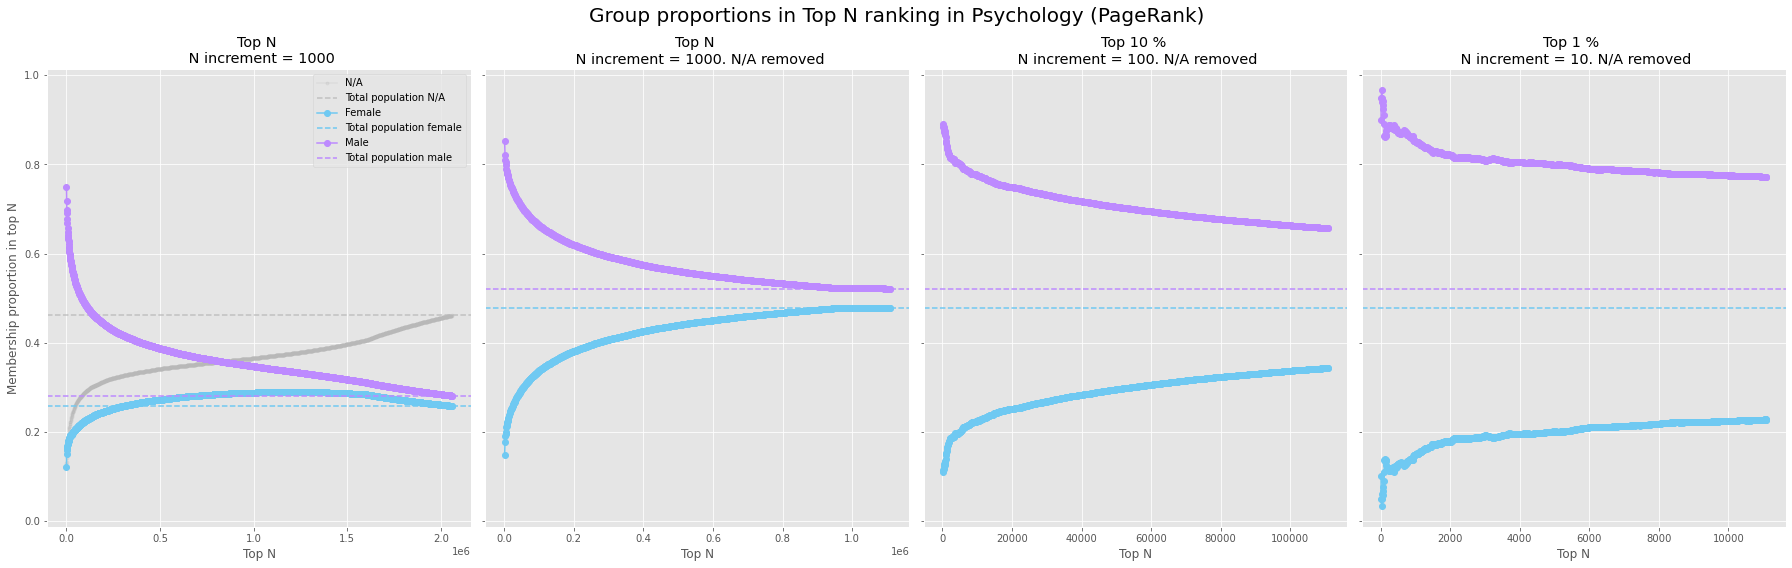

In [52]:
plot_side_by_side(cent_df, 'Psychology', interval=1000, figsize=(25,8), centrality="PageRank")

In [21]:
cent_df[:10]

,AuthorId,PageRank,PageRank05,InDegreeStrength,InDegree,OutDegreeStrength,OutDegree,Gender,Rank
1895323,968460832,0.001325,0.000528,19650.7770,17658.0,3.000000,3.000000,1,11308
1202609,2137065126,0.001166,0.000684,49866.9960,54321.0,3666.764200,3666.764200,1,11038
125279,467622467,0.000947,0.000436,22329.7500,27923.0,19.166666,19.166666,0,11565
1336062,2490080893,0.000879,0.000300,15904.7740,13884.0,1159.166600,1159.166600,-1,12048
1690847,1982301990,0.000768,0.000328,20830.6370,24780.0,5633.717000,5633.717000,-1,12042
577524,355673734,0.000717,0.000171,3242.3833,4578.0,27.500000,27.500000,-1,12201
2020262,1969121271,0.000683,0.000157,4560.8477,6147.0,214.250000,214.250000,1,12619
1698296,2157867866,0.000659,0.000352,11459.1980,25321.0,31.500000,31.500000,1,12516
334913,2026186952,0.000618,0.000274,10341.3920,19441.0,382.833340,382.833340,1,12640
256964,2134451896,0.000605,0.000241,12156.9890,17248.0,143.683330,143.683330,1,11875


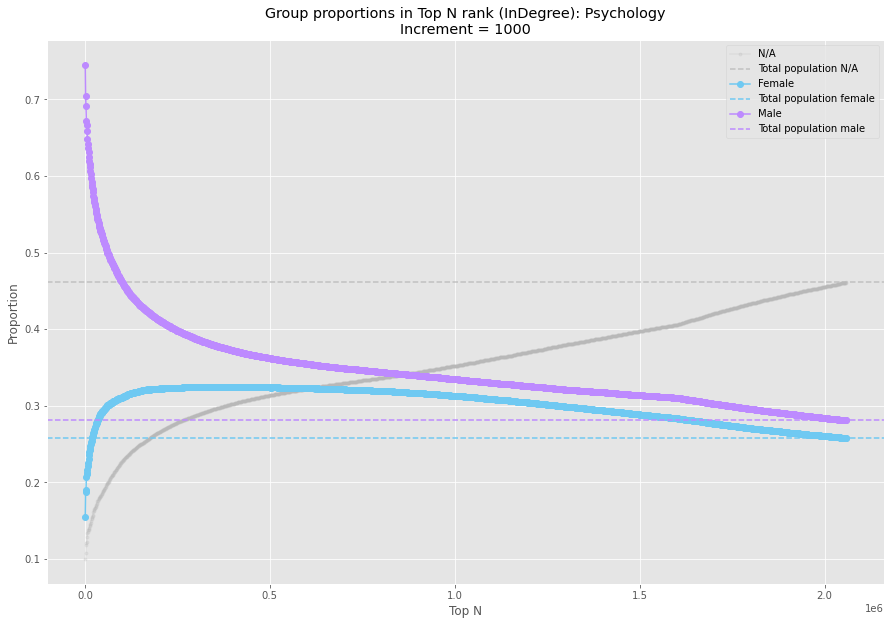

In [21]:
y, x = plot_group_dist(cent_df, 'InDegree', interval_size=1000, max_N=len(cent_df), protected_group=0, unprotected=1,
                       field_name="Psychology")

In [19]:
cent_df_filtered = cent_df.query("Gender != -1")

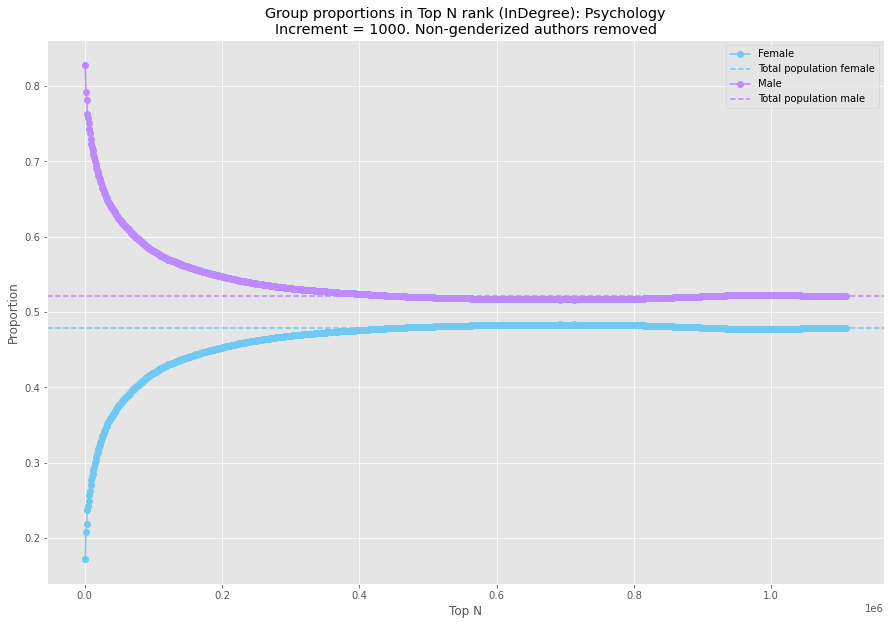

In [20]:
y, x = plot_group_dist(cent_df_filtered, 'InDegree', interval_size=1000, max_N=len(cent_df_filtered), 
                       protected_group=0, 
                       unprotected=1, 
                       show_unknown=False,
                       na_removed=True,
                       field_name="Psychology")

In [59]:
def plot_all_fields(centrality, interval=1000):
    
    field_mapping = {
        "Psychology": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightPsychology2010CentralityGendered.csv",
        "Economics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightEconomics2010CentralityGendered.csv", 
        "Mathematics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightMathematics2010CentralityGendered.csv",
        "Chemistry": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightChemistry2010CentralityGendered.csv",
    }
    
    for field_name, fpath in field_mapping.items():
        
        cent_df = pd.read_csv(fpath, sep="\t")
        cent_df['MAG Rank'] = cent_df['Rank'].apply(lambda x: x*-1)
        
        if centrality == 'Rank':
            centrality = 'MAG Rank'
                
        plot_side_by_side(cent_df, field_name, interval=1000, figsize=(25,8), centrality=centrality)
        
        #y, x = plot_group_dist(cent_df, centrality, interval_size=interval, max_N=len(cent_df), 
        #                       protected_group=0, 
        #                       unprotected=1, field_name=field_name)
        
        #cent_df_filtered = cent_df.query("Gender != -1")
        
        #y, x = plot_group_dist(cent_df_filtered, centrality, interval_size=interval, max_N=len(cent_df_filtered), 
        #                      protected_group=0, 
        #                       unprotected=1, field_name=field_name, show_unknown=False)
        

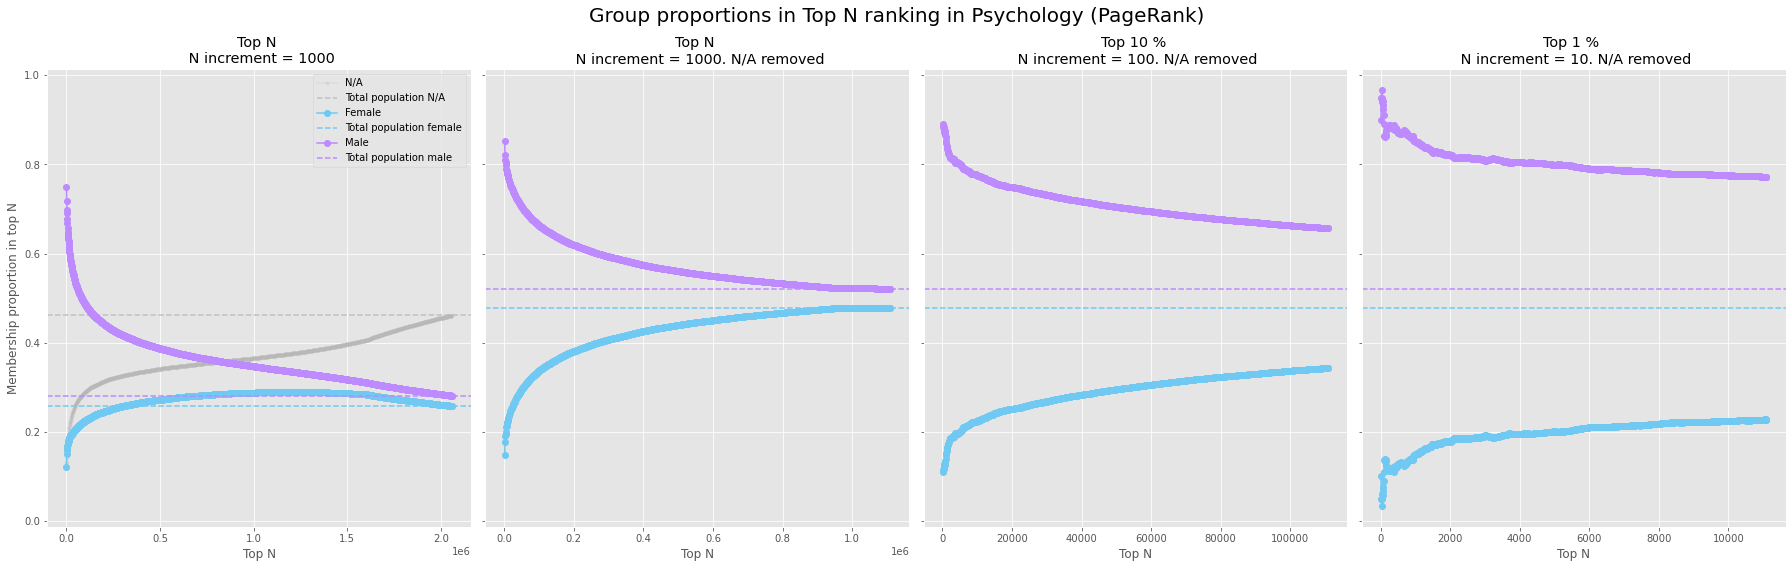

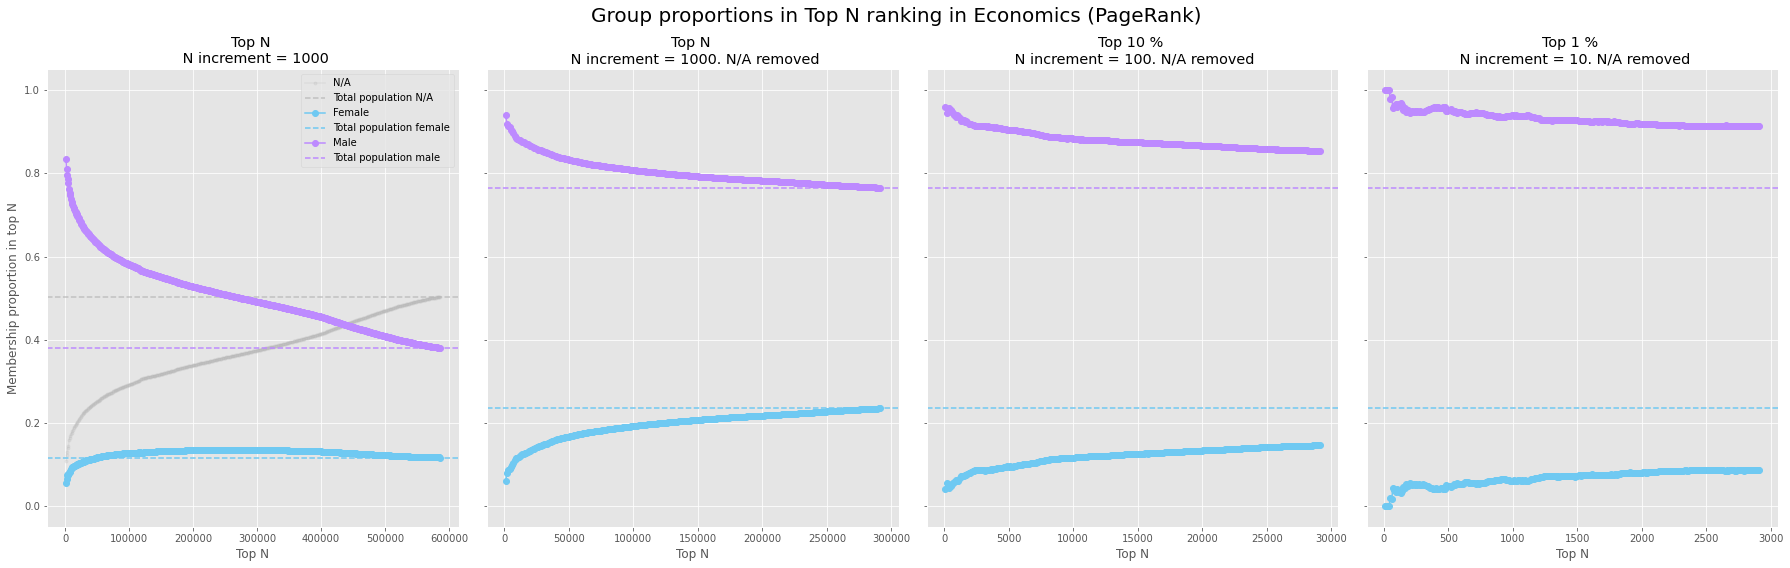

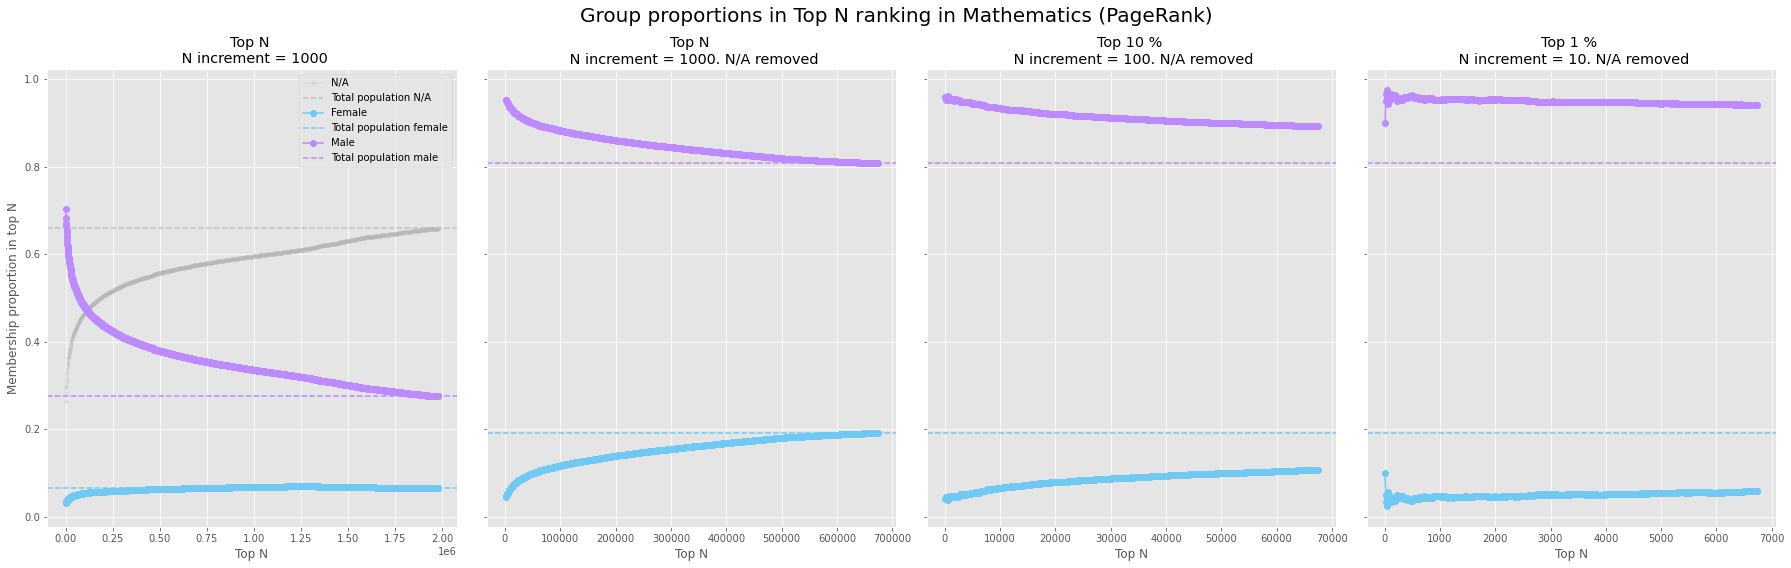

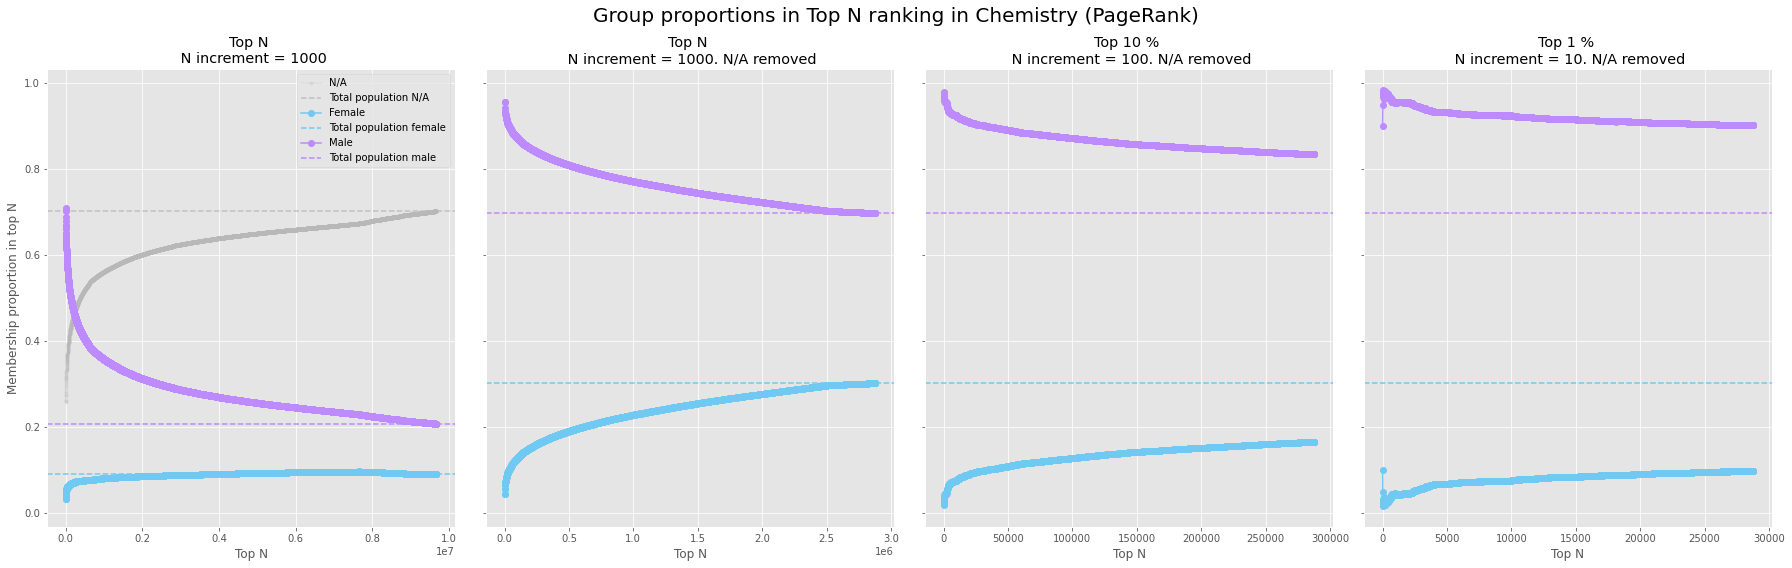

In [54]:
plot_all_fields('PageRank', 1000)

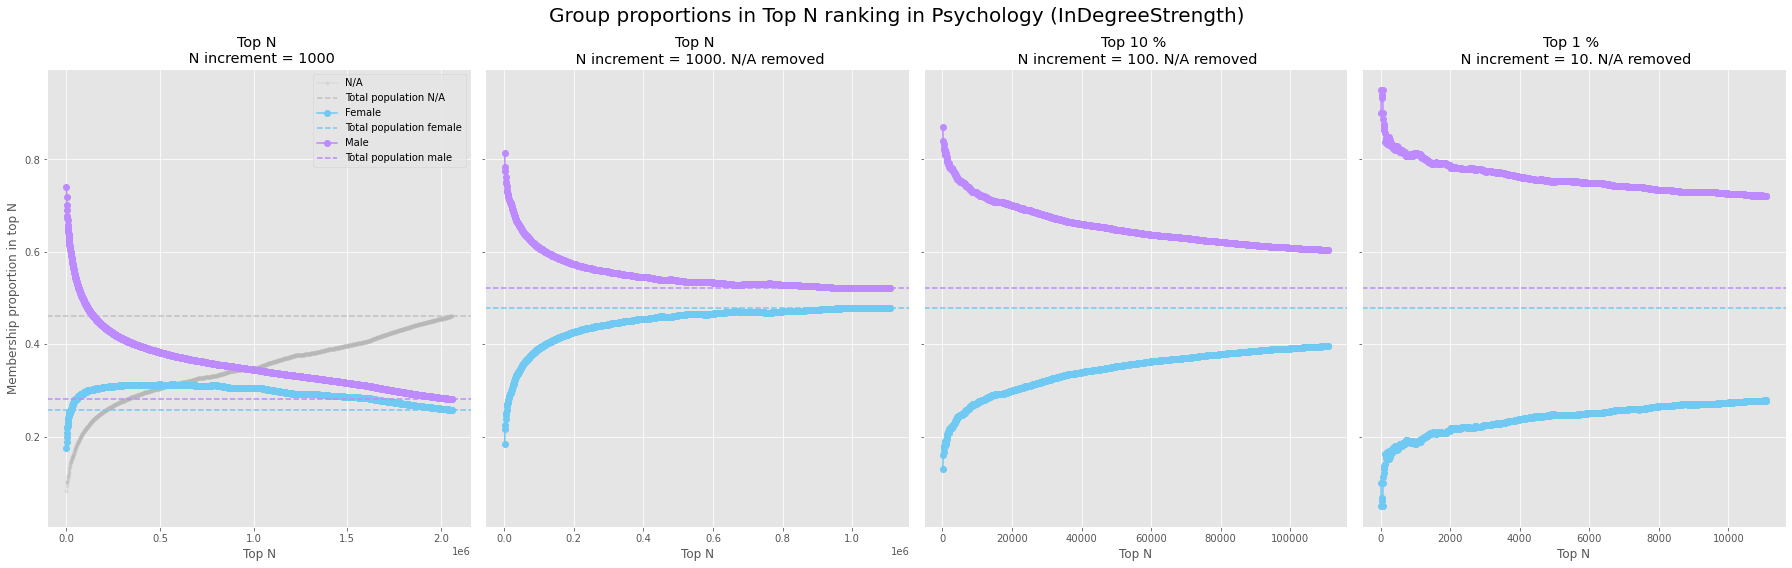

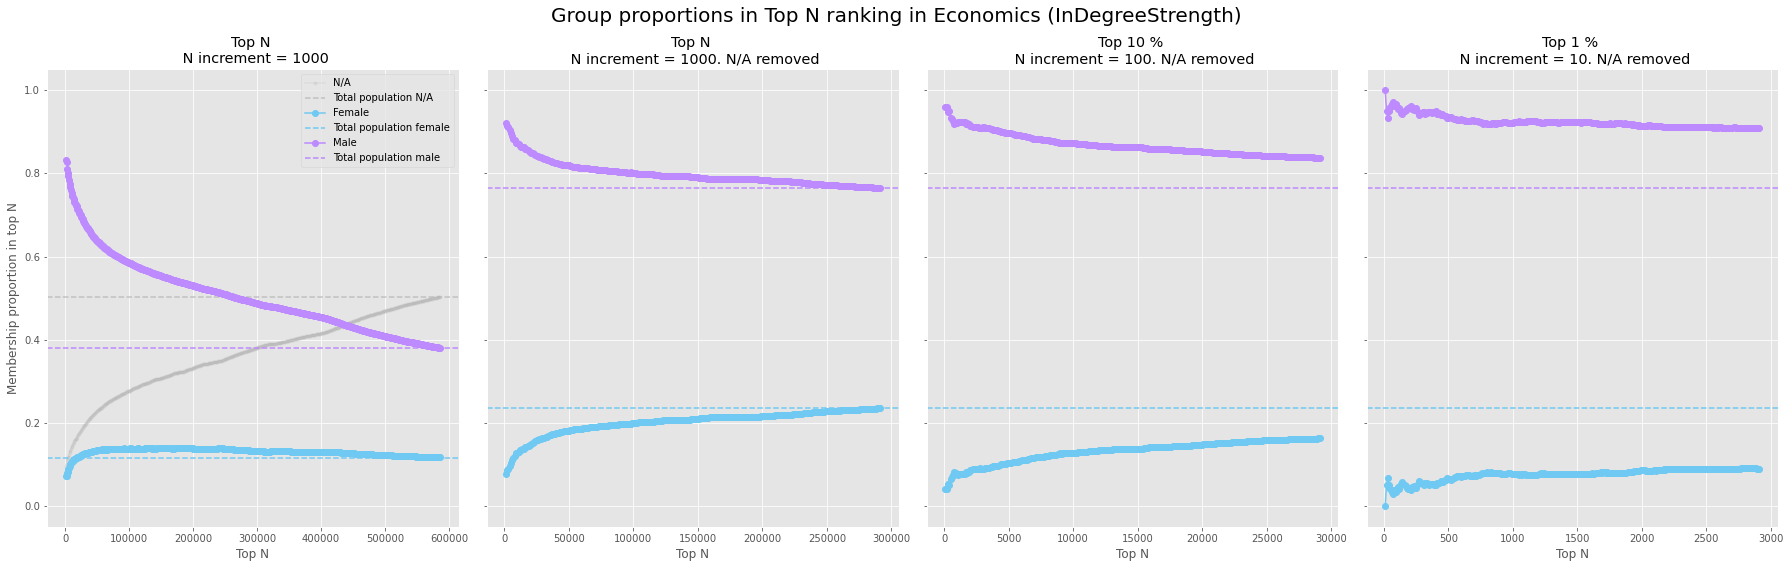

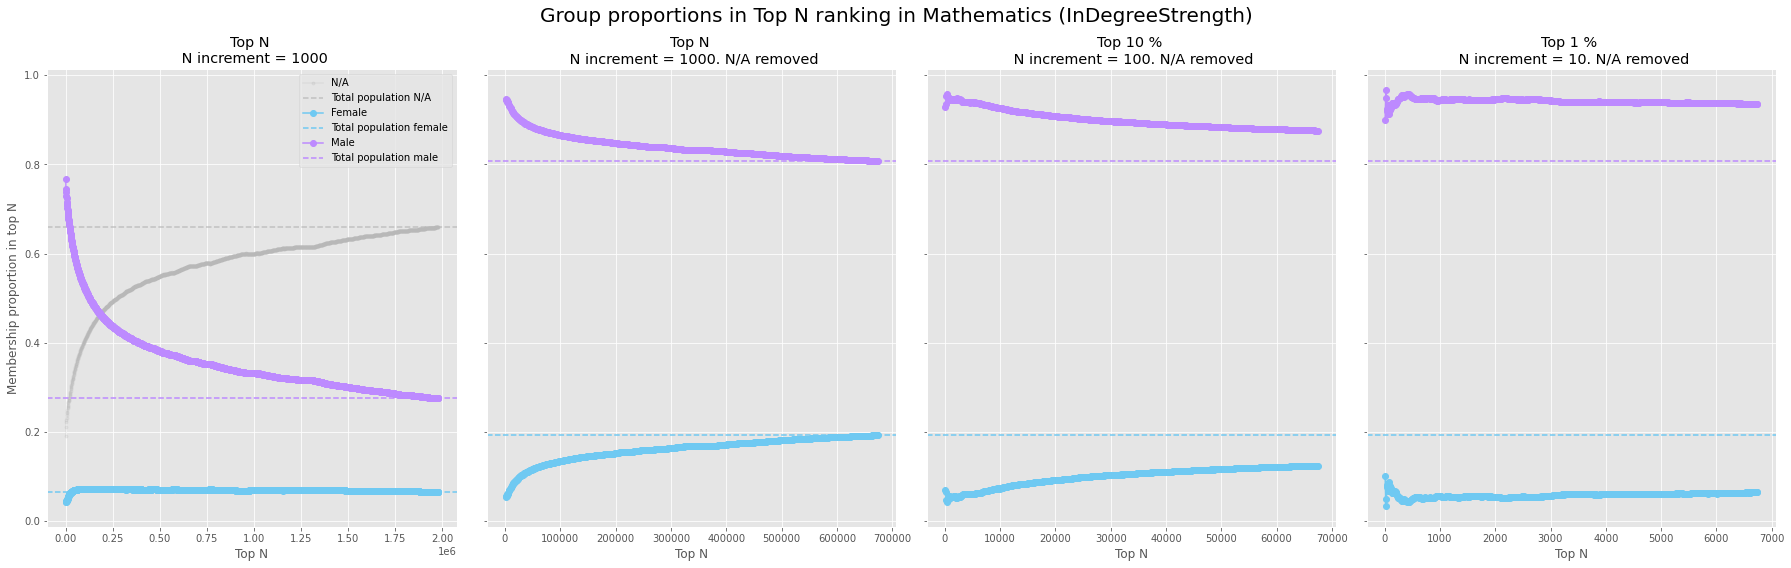

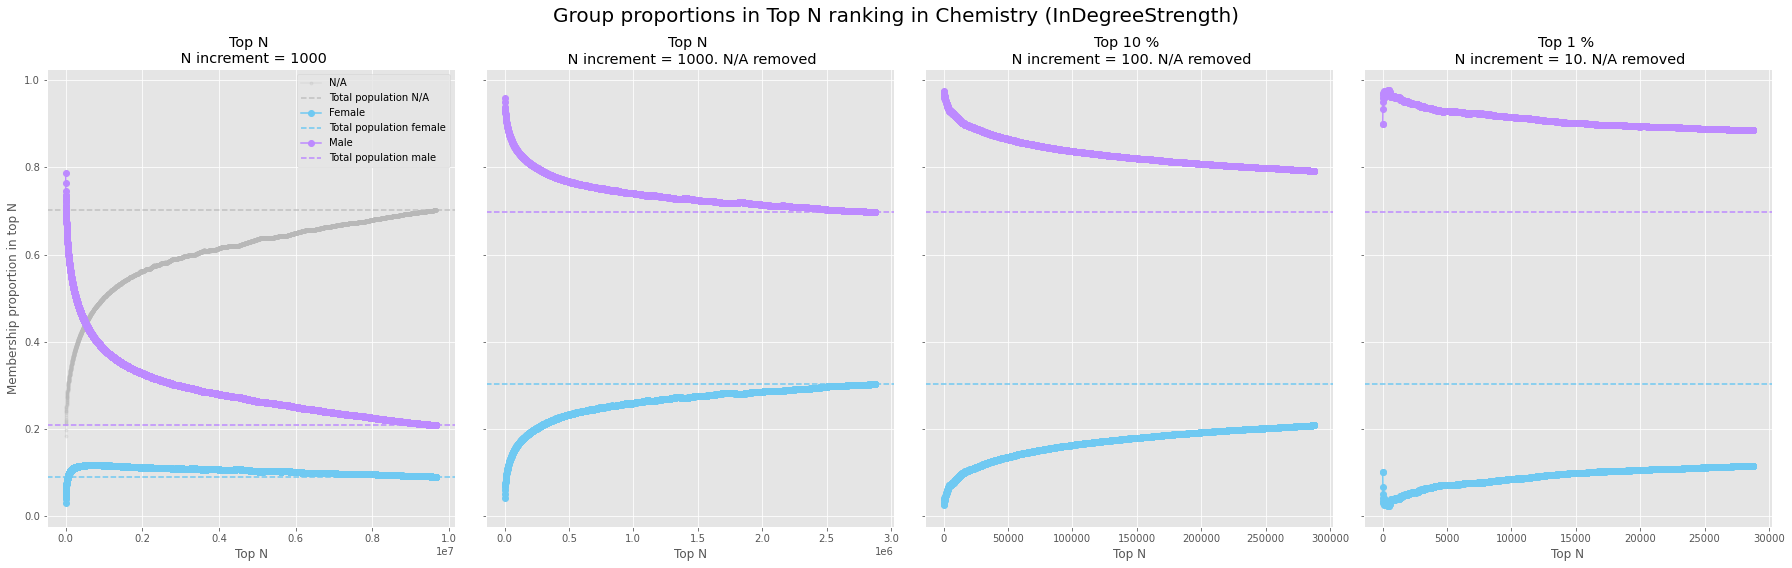

In [55]:
plot_all_fields('InDegreeStrength', 1000)

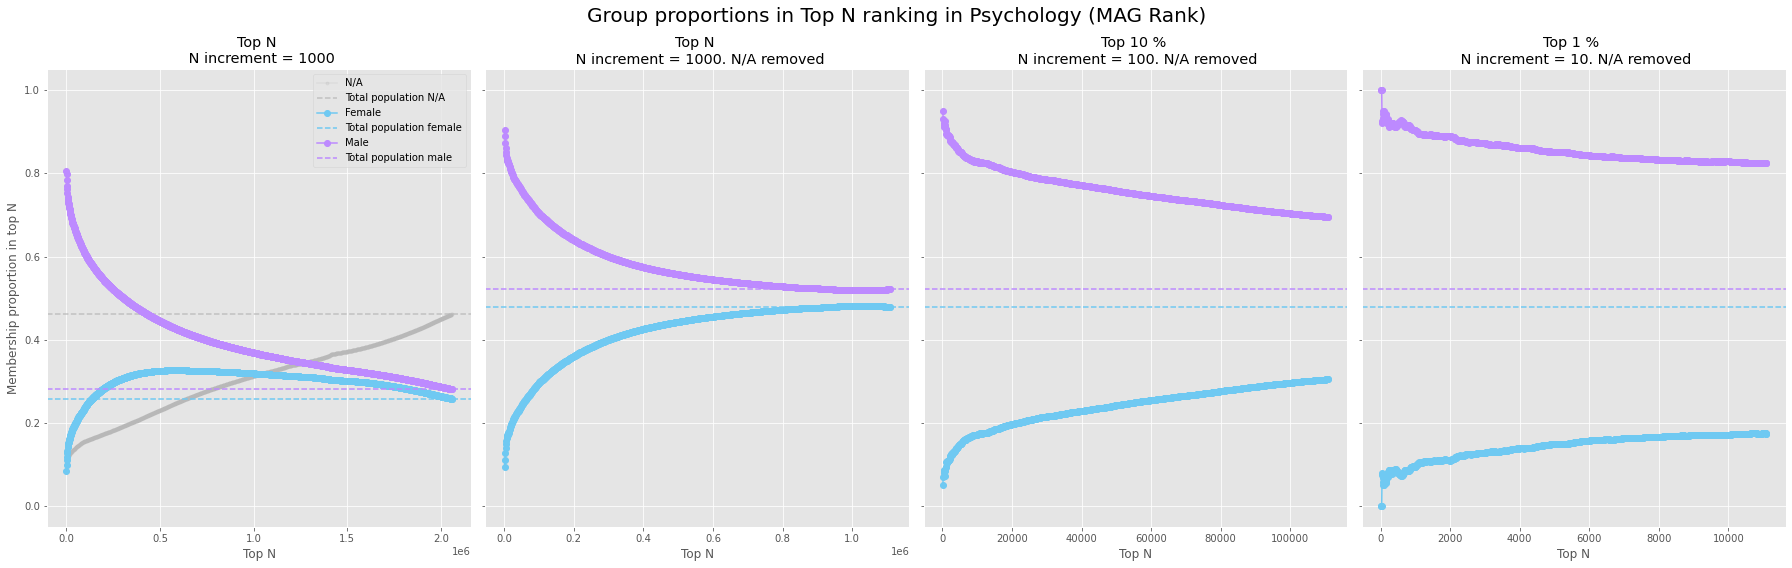

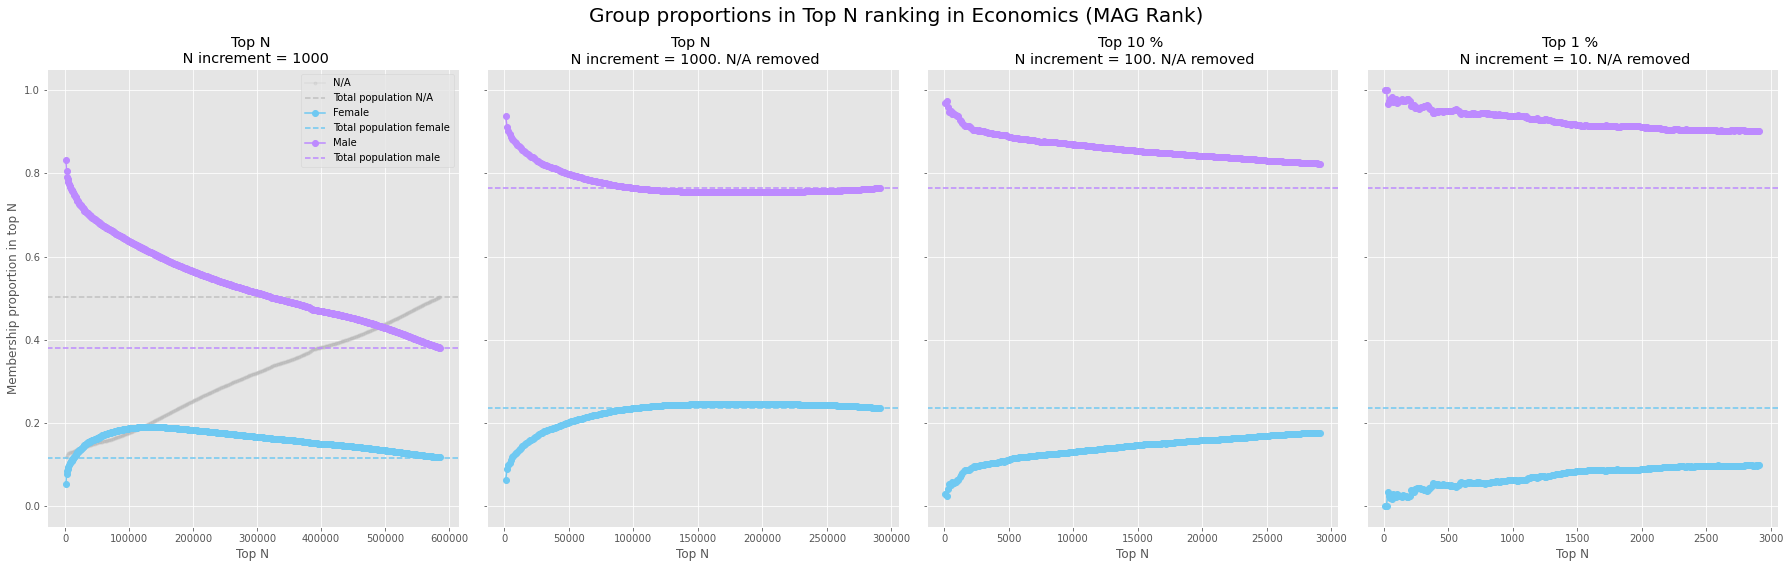

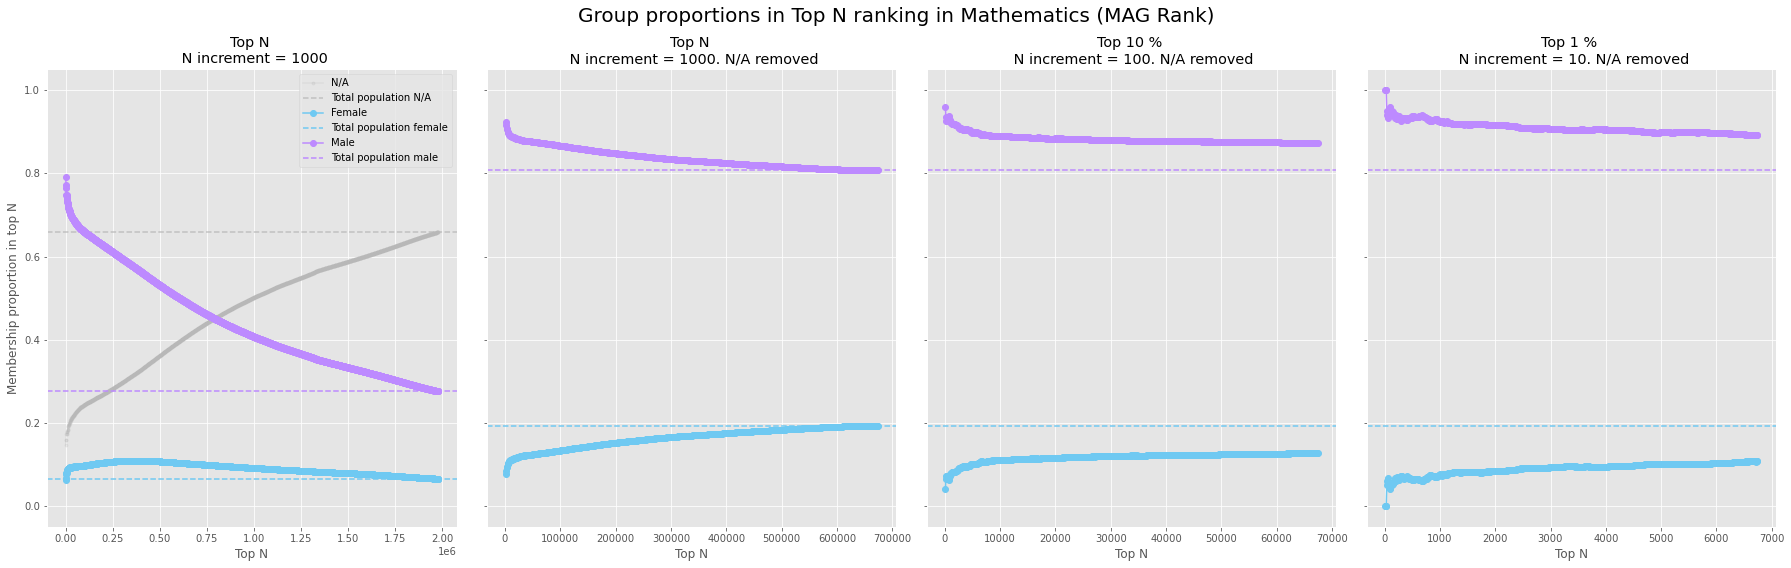

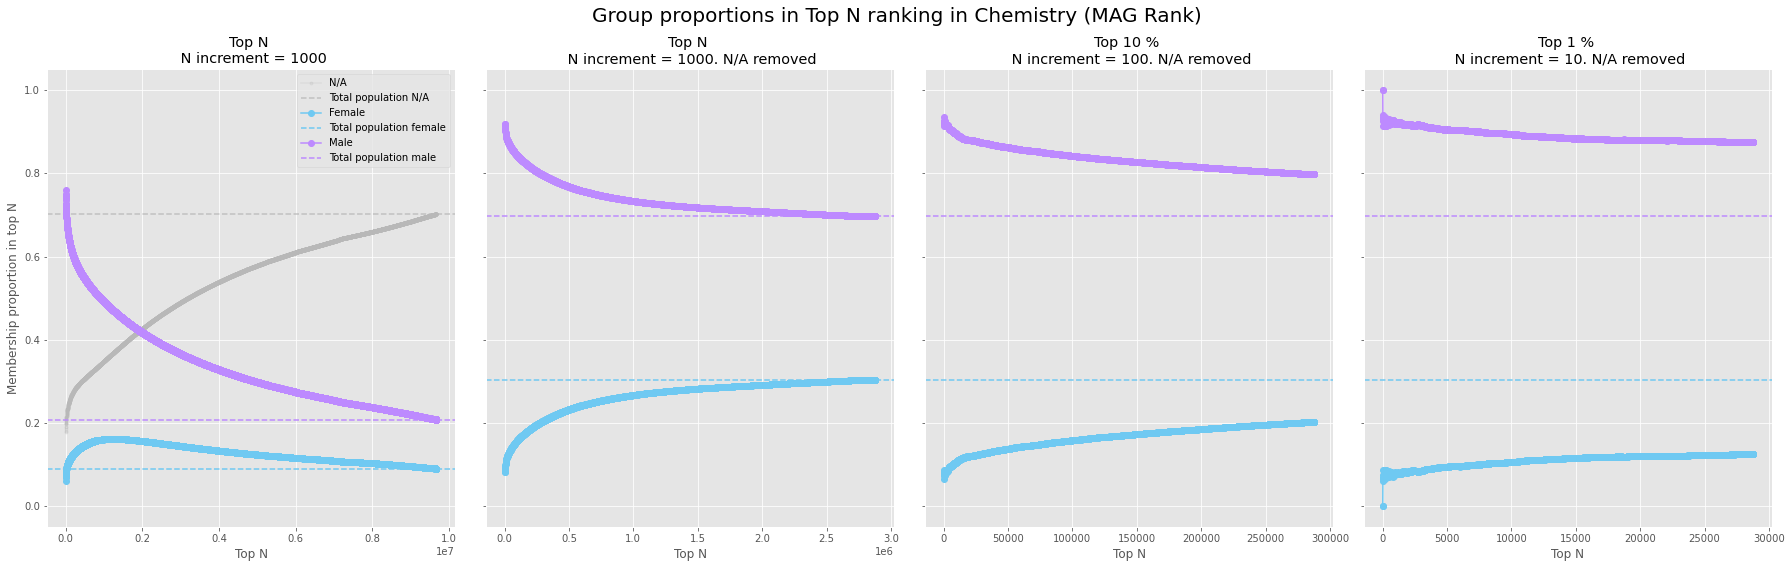

In [60]:
plot_all_fields('Rank', 1000)

In [36]:
def plot_group_dist_stacked(centrality_df, centrality, interval_size, max_N, protected_group, unprotected, 
                            show_unknown=True, field_name=None, na_removed=False, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    df = pd.DataFrame()
    
    sorted_df = centrality_df.sort_values(by=centrality, ascending=False)
    
    global_rate_protected = sorted_df.Gender.value_counts(normalize=True)[protected_group]
    global_rate_unprotected = sorted_df.Gender.value_counts(normalize=True)[unprotected]
    
    
    xticks = []
    y_values = []
    y_values_unprotected = []
    y_values_unknown = []
    
    for N in range(interval_size, max_N, interval_size):
        
        xticks.append(N)
        top_n_df = sorted_df[:N]
        y_values.append(top_n_df.Gender.value_counts(normalize=True)[protected_group])
        y_values_unprotected.append(top_n_df.Gender.value_counts(normalize=True)[unprotected])
        
        if show_unknown: y_values_unknown.append(top_n_df.Gender.value_counts(normalize=True)[-1])
    
    
    
    if show_unknown:
        global_rate_unknown = sorted_df.Gender.value_counts(normalize=True)[-1]
        ax.plot(xticks, y_values_unknown, '-o', label="N/A", markersize=3, color="#b8b8b8", alpha=0.2)
        ax.axhline(y=global_rate_unknown, label="Total population N/A", linestyle='--', alpha=0.8, color="#b8b8b8")
    
    
    
    
    df['Female'] = y_values
    df['Male'] = y_values_unprotected
    
    df.index = xticks
    
    if show_unknown:
        df['N/A'] = y_values_unknown

        
    ax = df.plot.area(stacked=True, ax=ax, alpha=0.8, linewidth=0)
        
    colors = ["#6fc9f2", "#bd8aff", "#b8b8b8"]
        
    for index, collection in enumerate(ax.collections):
        collection.set_facecolor(colors[index])
        
    #ax.plot(xticks, y_values, '-o', label="Female", markersize=6, color="#6fc9f2")
    
    ax.axhline(y=global_rate_protected, label="Total population female", linestyle='--', alpha=1.0, color="#6fc9f2")
    
    
    #ax.plot(xticks, y_values_unprotected, '-o', label="Male", markersize=6, color="#bd8aff")
    ax.axhline(y=global_rate_unprotected, label="Total population male", linestyle='--', alpha=1.0, color="#bd8aff")
    
    
    title = "Group proportions in Top N rank ({})".format(centrality)
    title += ": {}".format(field_name) if field_name is not None else ""
    title += "\nIncrement = {}".format(interval_size)
    title += ". Non-genderized authors removed" if na_removed else ""
    
    ax.set_title(title, fontsize=12)
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Top N")
    
    ax.legend()
    
    if ax is None:
        plt.show()
    
    return y_values, xticks

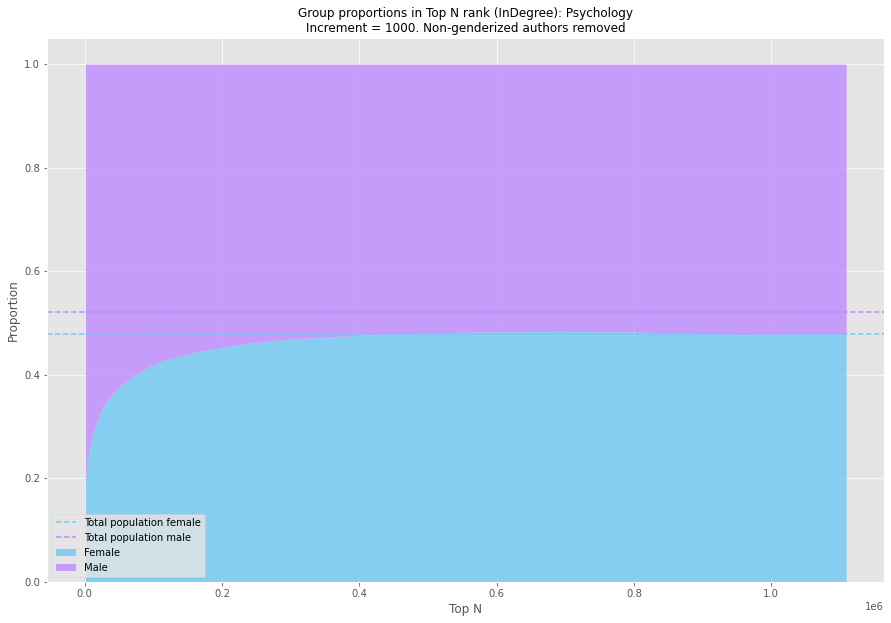

In [37]:
y, x = plot_group_dist_stacked(cent_df_filtered, 'InDegree', interval_size=1000, max_N=len(cent_df_filtered), 
                       protected_group=0, 
                       unprotected=1, 
                       show_unknown=False,
                       na_removed=True,
                       field_name="Psychology")

<AxesSubplot:ylabel='Frequency'>

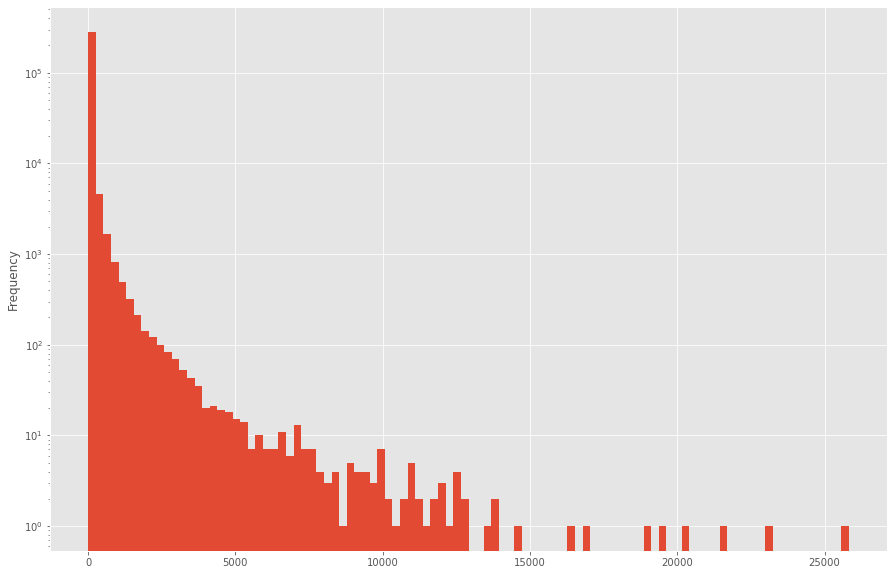

In [105]:
cent_df_filtered['InDegree'].plot(kind='hist', bins=100, log=True)

In [97]:
cent_df_filtered[['PageRank', 'Rank']].corr()

,PageRank,Rank
PageRank,1.000000,-0.162985
Rank,-0.162985,1.000000


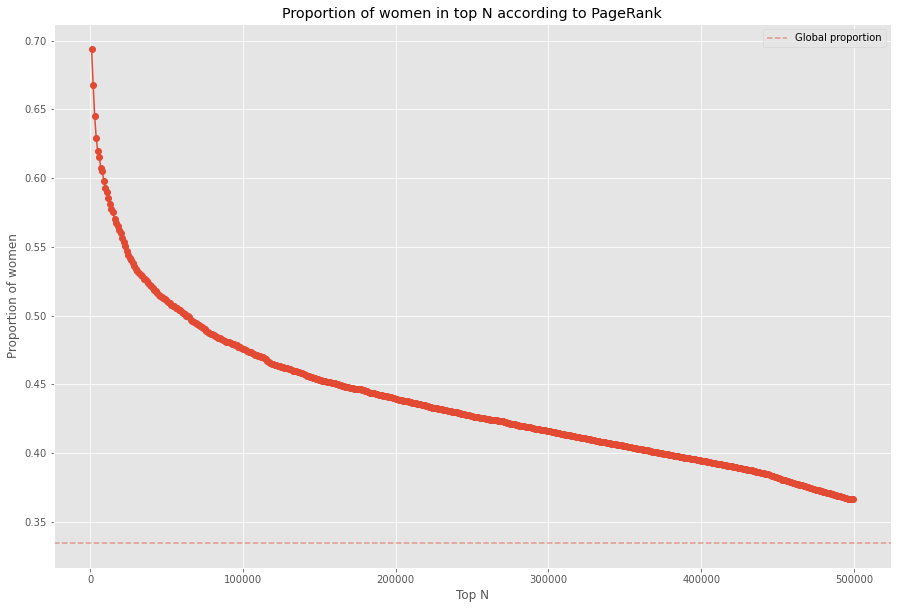

In [55]:
y,x = plot_group_dist(cent_df, 'PageRank', interval_size=1000, max_N=500000, protected_group=1)

In [29]:
cent_df[:11]

,AuthorId,PageRank,PageRank05,InDegreeStrength,InDegree,OutDegreeStrength,OutDegree,Gender,Rank
0,29087,7.099961e-07,0.000001,1.000000,1.0,0.000000,0.000000,-1,19035
1,599318,1.577505e-06,0.000002,1.000000,3.0,1.333333,1.333333,1,16691
2,869659,7.109015e-07,0.000001,0.600000,4.0,0.000000,0.000000,0,20475
3,1671721,1.130131e-05,0.000008,70.833336,199.0,35.166668,35.166668,0,12736
4,2069880,9.996813e-07,0.000001,1.375000,13.0,0.500000,0.500000,-1,16284
5,2128505,6.835849e-07,0.000001,0.000000,0.0,7.000000,7.000000,1,16842
6,2755080,6.835849e-07,0.000001,0.000000,0.0,7.500000,7.500000,-1,18157
7,3381675,9.267146e-07,0.000001,1.500000,4.0,1.000000,1.000000,0,18399
8,3546215,6.926638e-07,0.000001,0.500000,1.0,5.000000,5.000000,1,17172
9,3791134,8.106969e-07,0.000001,3.500000,14.0,23.000000,23.000000,1,16825


## Fairness measure comparison

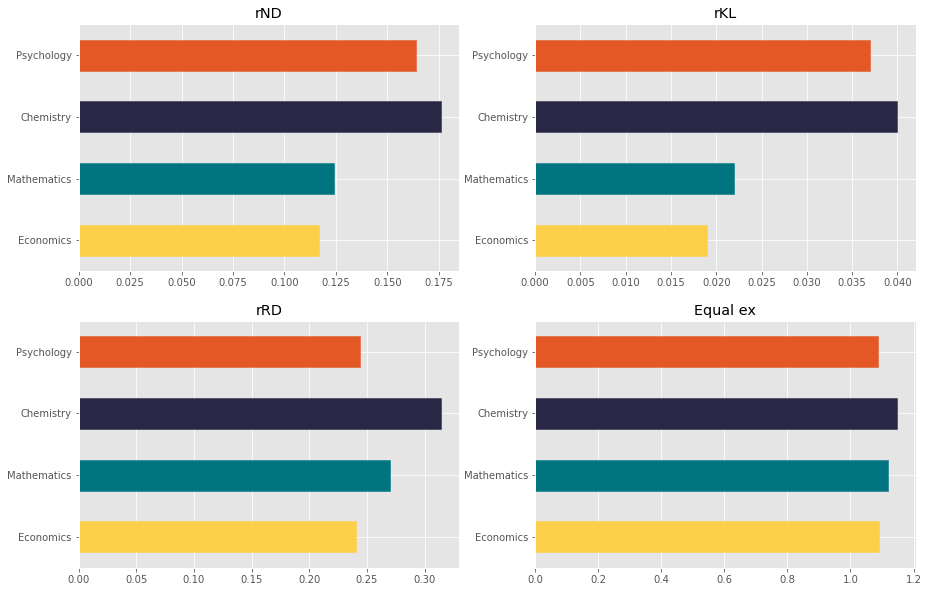

In [47]:
data = [[0.117, 0.019, 0.240, 1.092],
        [0.124, 0.022, 0.270, 1.119], 
        [0.176, 0.040, 0.314, 1.149],
        [0.164, 0.037, 0.244, 1.086]]

names = ['Economics', 'Mathematics', 'Chemistry', 'Psychology']

fairness_df = pd.DataFrame(data, columns=['rND', 'rKL', 'rRD', 'Equal ex'], 
                           index=names)

output = fairness_df.plot(kind='barh', subplots=True, layout=(2,2), sharex=False,
                         legend=None)

colors = ['#fed049', '#007580', '#282846', '#e45826']

for chart in output.flatten():    
    for idx, patch in enumerate(chart.patches):
        patch.set_color(colors[idx])
plt.show()

In [40]:
output.flatten()

array([<AxesSubplot:title={'center':'rND'}>,
       <AxesSubplot:title={'center':'rKL'}>,
       <AxesSubplot:title={'center':'rRD'}>,
       <AxesSubplot:title={'center':'Equal ex'}>], dtype=object)

In [38]:
output[0][0].patches[0].set_color()

<bound method Patch.set_color of <matplotlib.patches.Rectangle object at 0x7f443079de50>>

## Network viz

In [ ]:
fitoutput_indegree = powerlaw.Fit(cent_df['InDegree'].values)
fitoutput_indstrength = powerlaw.Fit(cent_df['InDegreeStrength'].values)

In [ ]:
def plot_ccdf_with_fits(fitoutput, title="CCDF"):
    """
    Plots complement of a cumulative distribution (CCDF) from the output of a 
    degree distribution fitted using the powerlaw package
        @fitoutput: Output of powerlaw.Fit() to the degree distribution of a network 
    """
    plt.figure()
    fig1 = fitoutput.plot_ccdf(label='CCDF', linestyle='--', marker='o')
    
    # add fitted powerlaw, exponential and lognormal CCDF plots as dashed lines
    fitoutput.power_law.plot_ccdf(ax=fig1, color='r', linestyle='--', label='power-law fit')
    fitoutput.exponential.plot_ccdf(ax=fig1, color='g', linestyle='--', label='exponential fit')
    fitoutput.lognormal.plot_ccdf(ax=fig1, color='b', linestyle='--', label='lognormal fit')
    fitoutput.truncated_power_law.plot_ccdf(ax=fig1, color='k', linestyle='--', label='Powerlaw w. exp. cutoff')

    plt.title(title)
    plt.legend()
    plt.ylim(0.001, 1.2)
    plt.xlabel('$x$')
    plt.ylabel('$P(k>=x)$')
    plt.show()

In [ ]:
plot_ccdf_with_fits(fitoutput_indstrength, "CCDF with distribution fits for in-degree")

In [ ]:
plot_ccdf_with_fits(fitoutput_indstrength, "CCDF with distribution fits for in-degree strength")

In [ ]:
plt.figure()
fitoutput_indstrength.plot_pdf(marker='o', linewidth=0, linear_bins=True)
plt.title("PDF for in-degree strength")
plt.xlabel("Strength")
plt.show()